https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-Job_descriptions

This project consists of finding a correlation between job descriptions and skills.

In [ ]:
# pip install numpy pandas sklearn wordcloud textblob

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, json file I/O (e.g. pd.read_json)
import string
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import Word

import os
for dirname, _, filenames in os.walk('/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
test = pd.read_csv('data-jobs-20221123.csv')
## Delete empty rows (In case I missed parsing a row)
test = test.dropna()
print("\n ** raw data **\n")
print(test.head())
print("\n ** data shape **\n")
print(test.shape)


 ** raw data **

    id                                company  \
0   76                             Braintrust   
1  372           Strategic Software Solutions   
2  120                                Convera   
3  200                               Glocomms   
4  184  Financial Services-Investment Banking   

                                           job_title  \
0  Identity and Access Management Senior Security...   
1                              Azure DevOps Engineer   
2                                Senior Data Analyst   
3                                       IAM Engineer   
4  Engineer, Application Security (Identity & Acc...   

                                      salary post_date  \
0  $100.00 - $115.00 Per Hour(Employer est.)  11/18/22   
1  $100.00 - $125.00 Per Hour(Employer est.)  10/27/22   
2              $100K - $120K (Employer est.)  11/17/22   
3              $100K - $120K (Employer est.)   11/8/22   
4              $100K - $125K (Employer est.)   9/14/22   

 

There are 451 jobs across 6 columns of data.

# 2. Clean Job Titles

<AxesSubplot: >

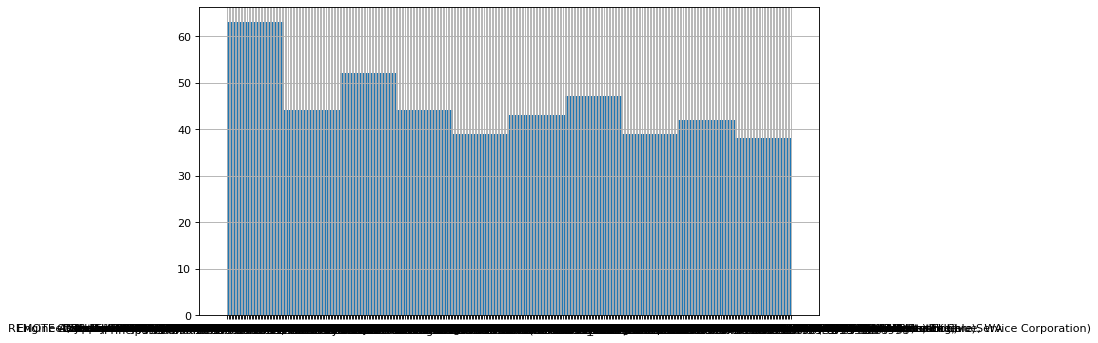

In [10]:
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
test.job_title.hist()

Preprocess text data
Since the data we're now working with is at its rawest form, we need to preprocess it before extracting information from it.

in this step, we will:

Convert all text to lower cases
Delete all tabulation,spaces, and new lines
Delete all numericals
Delete nltk's defined stop words
Lemmatize text

In [11]:
## Lower case
test['description'] = test['description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
test['description'] = test['description'].str.replace('[^\w\s]',' ', regex=True)
## digits
test['description'] = test['description'].str.replace('\d+', ' ', regex=True)

#remove stop words
stop = stopwords.words('english')
other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong', 'team', 'lumen', 'will', 'benefit']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

## lemmatization
test['description'] = test['description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print("Preprocessed data: \n")
print(test.head())


Preprocessed data: 

    id                                company  \
0   76                             Braintrust   
1  372           Strategic Software Solutions   
2  120                                Convera   
3  200                               Glocomms   
4  184  Financial Services-Investment Banking   

                                           job_title  \
0  Identity and Access Management Senior Security...   
1                              Azure DevOps Engineer   
2                                Senior Data Analyst   
3                                       IAM Engineer   
4  Engineer, Application Security (Identity & Acc...   

                                      salary post_date  \
0  $100.00 - $115.00 Per Hour(Employer est.)  11/18/22   
1  $100.00 - $125.00 Per Hour(Employer est.)  10/27/22   
2              $100K - $120K (Employer est.)  11/17/22   
3              $100K - $120K (Employer est.)   11/8/22   
4              $100K - $125K (Employer est.)   9/14/22   

Visualize data
In this step, we will aggregate our data by job titles in order to visualy detect the most frequent words for each job.

In [ ]:
## jda stands for job description aggregated
jda = test.groupby(['title']).sum().reset_index()
print("Aggregated job descriptions: \n")
print(jda)

In [ ]:
## Visualize data
jobs_list = jda.title.unique().tolist()
for job in jobs_list:

    # Start with one review:
    text = jda[jda.title == job].iloc[0].description
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate(text)
    print("\n***",job,"***\n")
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


In [ ]:
# remove other stop words

other_stop_words = ['junior', 'senior','experience','etc','job','work','company','technique',
                    'candidate','skill','skills','language','menu','inc','new','plus','years',
                   'technology','organization','ceo','cto','account','manager','data','scientist','mobile',
                    'developer','product','revenue','strong']

test['description'] = test['description'].apply(lambda x: " ".join(x for x in x.split() if x not in other_stop_words))

We are now going to translate this skill-extraction problem into a classification one first. And then extract the most important features from each class.

The most important features, in this case, represent the words that most likely will belong to a class ( in our case job title)

I chose for this exercise to train the naive bayes algorithm.

In [ ]:
## Converting text to features 
vectorizer = TfidfVectorizer()
#Tokenize and build vocabulary
X = vectorizer.fit_transform(test.description)
y = test.title

# split data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) 
print("train data shape: ",X_train.shape)
print("test data shape: ",X_test.shape)

# Fit model
clf = MultinomialNB()
clf.fit(X_train, y_train)
## Predict
y_predicted = clf.predict(X_test)

In [ ]:
y_train.hist()
y_test.hist()

In [ ]:
#evaluate the predictions
print("Accuracy score is: ",accuracy_score(y_test, y_predicted))
print("Classes: (to help read Confusion Matrix)\n", clf.classes_)
print("Confusion Matrix: ")

print(confusion_matrix(y_test, y_predicted))
print("Classification Report: ")
print(classification_report(y_test, y_predicted))

At this step, we have for each class/job a list of the most representative words/tokens found in job descriptions.

Let's shrink this list of words to only:

6 technical skills
6 adjectives
To do so, we use the library TextBlob to identify adjectives.

Also, given a (non-exhaustive) list of programming languages, we can extract the top technical skills.

In [ ]:
from textblob import TextBlob
technical_skills = ['python', 'c','r', 'c++','java','hadoop','scala','flask','pandas','spark','scikit-learn','numpy','php','sql','mysql','css','mongdb','nltk','fastai' , 'keras', 'pytorch','tensorflow','linux','Ruby','JavaScript','django','react','reactjs','ai','ui','tableau', 'directory', 'virtual directory', 'radiant logic', 'sailpoint', 'identity proofing', 'identity aggregations', 'identity lifecycle management', 'deprovisioning', 'account management', 'entitlements', 'attribute management', 'reconciliation', 'resolution', 'identity management', 'ldap','active directory', 'azure active directory', 'ad', 'aad', 'mim', 'microsoft identity manager', 'access reviews', 'identity governance and administration', 'identity governance', 'iga', 'recertification', 'identity management', 'entrust', 'venafi', 'one time pin', 'otp' 'FIDO', 'pki', 'enrollment', 'credential management', 'password', 'push notification', 'okta', 'ping', 'single sign-on', 'SSO', 'public key infrastructure', 'authentication', 'authorization', 'access management', 'abac', 'access control', 'saml', 'oidc', 'open id connect', 'active directory federation services', 'adfs', 'policy decision point', 'two-factor authentication', 'tfa', 'mfa', 'multifactor authentication', 'privileged access management', 'pam', 'cyberark', 'beyondtrust', 'thycotic',  'privileged account management', 'policy alignment', 'authentication broker', 'attribute exchange', 'trust framework', 'assertion service', 'federation assertion', 'saml', 'oidc', 'open id connect', 'security token service', 'sts', 
'trust relationship', 'azure', 'aws']
feature_array = vectorizer.get_feature_names()
# number of overall model features
features_numbers = len(feature_array)
## max sorted features number
n_max = int(features_numbers * 0.1)

##initialize output dataframe
output = pd.DataFrame()
for i in range(0,len(clf.classes_)):
    print("\n****" ,clf.classes_[i],"****\n")
    class_prob_indices_sorted = clf.feature_log_prob_[i, :].argsort()[::-1]
    raw_skills = np.take(feature_array, class_prob_indices_sorted[:n_max])
    print("list of unprocessed skills :")
    print(raw_skills)
    
    ## Extract technical skills
    top_technical_skills= list(set(technical_skills).intersection(raw_skills))[:6]
    #print("Top technical skills",top_technical_skills)
    
    ## Extract adjectives
    
    # Delete technical skills from raw skills list
    ## At this steps, raw skills list doesnt contain the technical skills
    #raw_skills = [x for x in raw_skills if x not in top_technical_skills]
    #raw_skills = list(set(raw_skills) - set(top_technical_skills))

    # transform list to string
    txt = " ".join(raw_skills)
    blob = TextBlob(txt)
    #top 6 adjective
    top_adjectives = [w for (w, pos) in TextBlob(txt).pos_tags if pos.startswith("JJ")][:6]
    #print("Top 6 adjectives: ",top_adjectives)
    
    output = output.append({'title':clf.classes_[i],
                        'technical_skills':top_technical_skills,
                        'soft_skills':top_adjectives },
                       ignore_index=True)

In [ ]:
print(output.T)